# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [1]:
# 程式區塊 A
# 將需要的都import進來
import os
import copy
import time
import math
import numpy             as np
import pandas            as pd
import seaborn           as sns
import datetime          as dt
import warnings
import matplotlib.pyplot as plt
from scipy                   import stats
from itertools               import compress
from sklearn.ensemble        import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.linear_model    import LogisticRegression,LinearRegression,Lasso
from sklearn.preprocessing   import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score

# 將較長的函式改名一下
MME  = MinMaxScaler()
LE   = LabelEncoder()
LR   = LogisticRegression()
LIR  = LinearRegression()
GBR  = GradientBoostingRegressor()
GBC  = GradientBoostingClassifier()


PDDF = pd.DataFrame()
# 一些必要的設定
warnings.filterwarnings('ignore')
%matplotlib inline

# 設定【data的資料夾路徑】，命名為【data_folder】
data_folder = 'C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data'

In [2]:
# 設定t001為某個data路徑
# 設定t002為pd裡read data的功能
t001_train = os.path.join(data_folder, 'titanic_train.csv')
t002_train = pd.read_csv(t001_train)
print('Path of read in data: %s' %t001_train)
print(t002_train.shape)
t002_train.head()

Path of read in data: C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data\titanic_train.csv
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 設定t001為某個data路徑
# 設定t002為pd裡read data的功能
t001_test  = os.path.join(data_folder,  'titanic_test.csv')
t002_test  = pd.read_csv(t001_test)
print('Path of read in data: %s' %t001_test)
print(t002_test.shape)
t002_test.head()

Path of read in data: C:/Users/Ynitsed/Documents/GitHub/2nd-ML100Days/data\titanic_test.csv
(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# 程式區塊 B-1：train取【Survived】為Y、test取【PassengerId】為最終將比對的唯一識別
train_Y     = t002_train['Survived']
test_unique = t002_test['PassengerId']
# 程式區塊 B-2：train捨棄【PassengerId,Survived】、test捨棄【PassengerId】。
t003_train = t002_train.drop(['PassengerId', 'Survived'] , axis=1)
t003_test  = t002_test.drop(['PassengerId'] , axis=1)
print(t003_train.shape)
print(t003_test.shape)

(891, 10)
(418, 10)


In [5]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
for d in t003_train.columns:
    t003_train[d] = t003_train[d].fillna(-1)
    if t003_train[d].dtype == 'object':
        t003_train[d] = LE.fit_transform(list(t003_train[d].values))
    t003_train[d] = MME.fit_transform(t003_train[d].values.reshape(-1, 1))
print(t003_train.shape)    
t003_train.head()

(891, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [6]:
# 梯度提升樹擬合後, 將結果依照重要性由高到低排序 
GBC.fit(t003_train.values, train_Y)
feats = pd.Series(data=GBC.feature_importances_, index=t003_train.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.444327
Pclass      0.111696
Ticket      0.098432
Fare        0.087046
Name        0.081535
Age         0.073659
Cabin       0.071699
Embarked    0.012246
Parch       0.011553
SibSp       0.007808
dtype: float64

## 先用梯度提升機對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?
> 雖然範例與作業當中, 看似高重要性特徵的預估正確率較差,  
但這是只使用一半特徵的結果, 表示高重要特徵的資訊密度是高的, 
使用較少特徵, 泛化能力(對外部資料預測力)也會提升,  
因此只要不要刪到一半那麼多, 仍可能是適當的特徵選擇方式  
另一個原因也可能是這邊的模型(GradientBoostingClassifier)並未經過調參, 所以特徵重要性排名較不準確導致

In [7]:
# 原始特徵 + 梯度提升樹
train_X = MME.fit_transform(t003_train)
print(train_X.shape)
print(f'Logistic Reg Score : {cross_val_score(LR, train_X, train_Y, cv=5).mean()}')
print(f'Linear Reg Score : {cross_val_score(LIR, train_X, train_Y, cv=5).mean()}')
print(f'Gradient Boosting Reg Score : {cross_val_score(GBR, train_X, train_Y, cv=5).mean()}')

(891, 10)
Logistic Reg Score : 0.8024647606361757
Linear Reg Score : 0.36310487684113124
Gradient Boosting Reg Score : 0.43791999827766803


In [8]:
# 高重要性特徵 + 梯度提升樹 
high_feature = list(feats[:5].index)
train_X = MME.fit_transform(t003_train[high_feature])
print(train_X.shape)
print(f'Logistic Reg Score : {cross_val_score(LR, train_X, train_Y, cv=5).mean()}')
print(f'Linear Reg Score : {cross_val_score(LIR, train_X, train_Y, cv=5).mean()}')
print(f'Gradient Boosting Reg Score : {cross_val_score(GBR, train_X, train_Y, cv=5).mean()}')

(891, 5)
Logistic Reg Score : 0.7833630696219254
Linear Reg Score : 0.3510058539013281
Gradient Boosting Reg Score : 0.4026937318883131


# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?
> 範例中我們可以看出, 加.乘.除三個特徵加上去後未必比較好  
但是作業中只挑選加與乘, 效果就有上升了  
因此這些特徵要組合, 未必就有一定的方式  
還需要參考領域知識, 才有可能有更有用的特徵組合

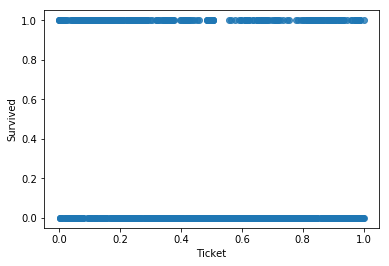

In [9]:
# 觀察重要特徵與目標的分布
# 第一名 : Ticket              
sns.regplot(x=t003_train['Ticket'], y=train_Y, fit_reg=False)
plt.show()

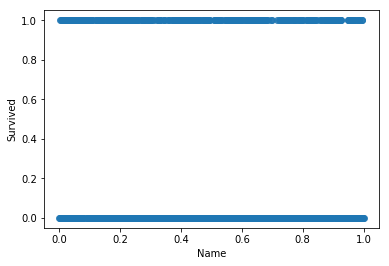

In [10]:
# 第二名 : Name        
sns.regplot(x=t003_train['Name'], y=train_Y, fit_reg=False)
plt.show()

In [11]:
# 製作二特徵 : 加, 乘
t003_train['Add_char']   = (t003_train['Ticket'] + t003_train['Name']) / 2
t003_train['Multi_char'] =  t003_train['Ticket'] * t003_train['Name']


In [12]:
print(t003_train.shape)    
t003_train.head()

(891, 12)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Add_char,Multi_char
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000,0.445233,0.093331
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333,0.544977,0.187112
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000,0.690226,0.390213
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000,0.188838,0.022022
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000,0.355486,0.011699


In [13]:
# 製作二特徵 : 加, 乘
t003_train['Add_char']   = (t003_train['Ticket'] + t003_train['Name']) / 2
t003_train['Multi_char'] =  t003_train['Ticket'] * t003_train['Name']
train_X = MME.fit_transform(t003_train)
print(train_X.shape)
print(f'Logistic Reg Score : {cross_val_score(LR, train_X, train_Y, cv=5).mean()}')
print(f'Linear Reg Score : {cross_val_score(LIR, train_X, train_Y, cv=5).mean()}')
print(f'Gradient Boosting Reg Score : {cross_val_score(GBR, train_X, train_Y, cv=5).mean()}')

(891, 12)
Logistic Reg Score : 0.8013348171333508
Linear Reg Score : 0.36141917509989757
Gradient Boosting Reg Score : 0.45535333477959183


### Day29教材方向和目標
[社群提問](https://www.cupoy.com/qa/kwassist/ai_tw/0000016AD812C2B6000001C06375706F795F72656C656173655155455354)

### Day29忽略部分

### Day29其他補充
如社群提問，不多說，我認為本日教材有問題，相加相乘的說法也不甚合理。